## Importowanie bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer

pd.set_option('display.max_columns', 100)

#### Załadowanie ocen ze zbioru Jester

In [2]:
ratings = pd.DataFrame()
for i in [1, 2, 3]:
    ratings_df = pd.read_excel(f'ratings/jester-data-{i}.xls', header=None)
    ratings_df = ratings_df.iloc[:, 1:].replace(99, float('nan'))
    ratings = pd.concat([ratings_df, ratings], ignore_index=True)
print(ratings)

        1     2     3     4     5     6     7     8     9     10    11    12   \
0       NaN   NaN   NaN   NaN -1.65   NaN -0.78  6.89   NaN   NaN   NaN   NaN   
1       NaN   NaN   NaN   NaN -9.27   NaN -9.17 -8.59   NaN   NaN   NaN   NaN   
2       NaN   NaN   NaN   NaN -6.12   NaN -7.48 -7.77   NaN   NaN   NaN   NaN   
3       NaN  0.05   NaN   NaN -2.82   NaN -4.85 -0.87   NaN   NaN   NaN   NaN   
4       NaN   NaN   NaN   NaN -4.95   NaN  6.21  2.72   NaN -8.59   NaN   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
73416  0.44  7.43  9.08  2.33  3.20  6.75 -8.79 -0.53 -8.74  7.23 -0.53  5.63   
73417  9.13 -8.16  8.59  9.08  0.87 -8.93 -3.50  5.78 -8.11  4.90  8.88 -8.69   
73418   NaN   NaN   NaN   NaN -7.77   NaN  6.70 -6.75   NaN   NaN   NaN   NaN   
73419   NaN   NaN   NaN   NaN -9.71   NaN  4.56 -8.30   NaN   NaN   NaN   NaN   
73420  2.43  2.67 -3.98  4.27 -2.28  7.33  2.33  4.56  6.75  4.61 -3.16  7.38   

        13    14    15    1

#### Uśrednianie wartości ocen dla każdego z żartów

In [3]:
ratings = ratings.mean()
print(ratings)
print(f'\nMax: {np.max(ratings)}')
print(f'Min: {np.min(ratings)}\n')


1      0.901997
2      0.162989
3      0.193411
4     -1.412599
5      0.235352
         ...   
96     1.373027
97     1.489106
98     0.869864
99    -0.036189
100    1.116812
Length: 100, dtype: float64

Max: 3.3625929395733083
Min: -3.704540991199629



#### Załadowanie żartów ze zbioru Jester

In [4]:
jokes = []
for i in range(1, 101):
    file_name = f'jokes/init{i}.html'
    with open(file_name, 'r') as file:
        html_code = file.read()
        soup = BeautifulSoup(html_code, 'html.parser')
        joke = soup.find('font', size='+1').text.strip()
        jokes.append(joke)
jokes[:5]

['A man visits the doctor. The doctor says "I have bad news for you.You have\n                    cancer and Alzheimer\'s disease". \n                    The man replies "Well,thank God I don\'t have cancer!"',
 'This couple had an excellent relationship going until one day he came home\nfrom work to find his girlfriend packing. He asked her why she was leaving him\nand she told him that she had heard awful things about him. \n\n"What could they possibly have said to make you move out?" \n\n"They told me that you were a pedophile." \n\nHe replied, "That\'s an awfully big word for a ten year old."',
 "Q. What's 200 feet long and has 4 teeth? \n\nA. The front row at a Willie Nelson Concert.",
 "Q. What's the difference between a man and a toilet? \n\nA. A toilet doesn't follow you around after you use it.",
 "Q.\tWhat's O. J. Simpson's Internet address? \nA.\tSlash, slash, backslash, slash, slash, escape."]

#### Generowanie wektorów osadzenia BERT dla załadowanych żartów

In [5]:
model = SentenceTransformer('bert-base-cased')
embeddings = model.encode(jokes)    #   encoding the jokes and changing text values into vectors

print('\nKształt macierzy z osadzeniami:')
print(embeddings.shape)
print('\nPrzykładowe wektory osadzenia:')
print(embeddings[:5])


No sentence-transformers model found with name C:\Users\Lenovo/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\Lenovo/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassifica


Kształt macierzy z osadzeniami:
(100, 768)

Przykładowe wektory osadzenia:
[[ 0.22689956  0.08085244  0.1937923  ...  0.3482189   0.16816409
   0.22305498]
 [ 0.08381999  0.15879391 -0.1869314  ...  0.24138355 -0.09729489
  -0.13394882]
 [ 0.02886741  0.04255899 -0.07353059 ...  0.244685    0.04791432
  -0.17327294]
 [ 0.35024592 -0.16287665  0.02111008 ...  0.29077908  0.01691803
  -0.28791642]
 [ 0.21226712  0.17400311  0.33756024 ...  0.19055374  0.31695113
  -0.0464093 ]]


#### Normalizowanie danych zawartych w wektorze i podział danych na zbiór testowy i walidacyjny

In [6]:
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(
    embeddings,
    ratings,
    test_size=.2,
    random_state=3
)

print(f'\nx_train: \n{x_train[:5]}')
print(f'\nx_test: \n{x_test[:5]}')

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f'\nx_train_scaled: \n{x_train_scaled[:5]}')
print(f'\nx_test_scaled: \n{x_test_scaled[:5]}')

print(f'\ny_train: \n{y_train[:5]}')
print(f'\ny_test: \n{y_test[:5]}')
print("x_train_scaled shape:", x_train_scaled.shape)
print("y_train shape:", y_train.shape)
print("x_test_scaled shape:", x_test_scaled.shape)
print("y_test shape:", y_test.shape)



x_train: 
[[ 0.31417006 -0.08046159 -0.08047681 ...  0.307418   -0.063332
  -0.20859025]
 [ 0.2305715  -0.22438778  0.03877632 ...  0.18961959  0.07735121
   0.02131943]
 [ 0.27073336  0.01967529 -0.02900464 ...  0.42462903 -0.13430595
   0.11279823]
 [ 0.21226712  0.17400311  0.33756024 ...  0.19055374  0.31695113
  -0.0464093 ]
 [ 0.04042921  0.03805169 -0.16368282 ...  0.20318852  0.1348443
   0.09576751]]

x_test: 
[[ 0.07865273 -0.0068186   0.18195361 ...  0.07392972  0.32631117
   0.06495202]
 [ 0.16786718  0.00867376  0.02094251 ...  0.22942364 -0.03718427
  -0.11140555]
 [ 0.2294442   0.19735843 -0.25905502 ...  0.19276005 -0.01912472
   0.06460596]
 [-0.02134267 -0.00345616 -0.10737845 ...  0.21202154  0.03590166
  -0.13674727]
 [ 0.3865879  -0.16756287  0.0988778  ...  0.44387668  0.06891792
   0.04738632]]

x_train_scaled: 
[[ 1.2375392  -0.6292926  -0.6543283  ...  0.4070948  -0.6023987
  -1.7983452 ]
 [ 0.6216753  -1.6148163   0.25107378 ... -0.5500831   0.4040223
   0.24

#### Testowanie modelu MLP Regressor przy domyślnej konfiguracji hiperparametrów

In [7]:
def run(mode, _learning_rate='constant', _learning_rates_init=0.001, _hidden_layer_sizes=(100,), _random_state=None, _alpha=0.0):
    mlp = MLPRegressor(
        solver='sgd',
        alpha=_alpha,
        learning_rate=_learning_rate,    # constant, invscaling, adaptive',
        learning_rate_init=_learning_rates_init,   # default step (how much weight sizes are adjusted each time)
        hidden_layer_sizes=_hidden_layer_sizes,    # number of neurons in each layer
        random_state=_random_state,
    )

    train_loss = []
    test_loss = []
    epochs_values = 1000

    for _ in range(epochs_values):
        mlp.partial_fit(x_train_scaled, y_train)
        pred_y_train = mlp.predict(x_train_scaled)
        pred_y_test = mlp.predict(x_test_scaled)
        
        train_loss.append(mean_squared_error(y_train, pred_y_train))
        test_loss.append(mean_squared_error(y_test, pred_y_test))
    loss_curve = mlp.loss_curve_
    
    if mode == 'train':
        return train_loss
    elif mode == 'test':
        return test_loss
    else:
        return loss_curve

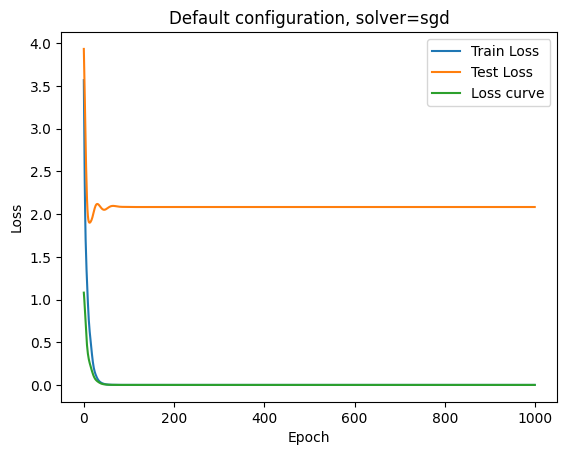

In [23]:
train_loss = run(mode='train')
test_loss = run(mode='test')
loss_curve = run(mode='loss_curve')

plt.title(f'Default configuration, solver=sgd')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(train_loss)), train_loss, label=f'Train Loss')
plt.plot(range(len(test_loss)), test_loss, label=f'Test Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.legend()
plt.show()
    

#### Badanie wpływu tempa uczenia na otrzymywane wyniki

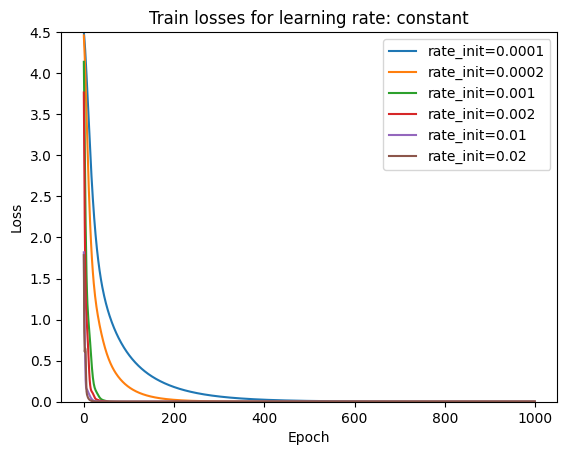

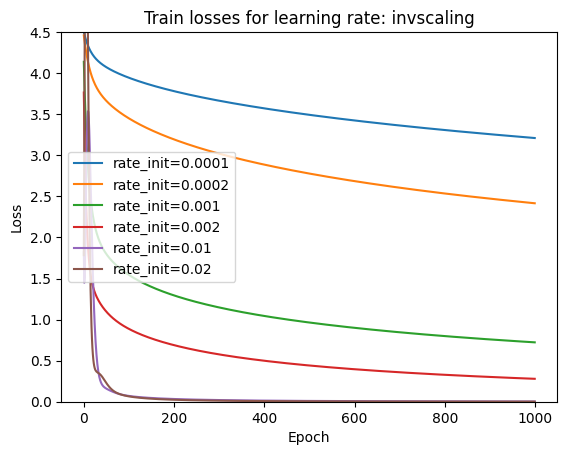

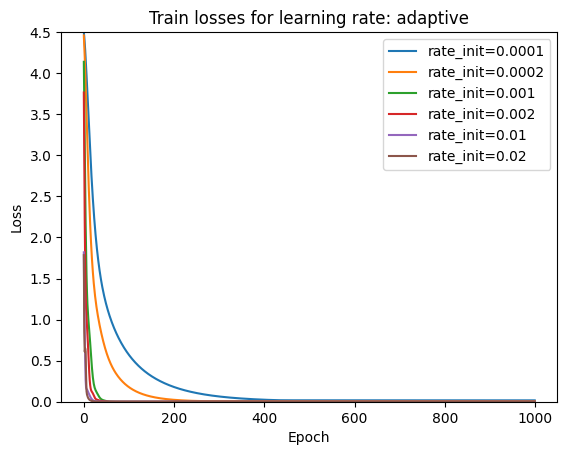

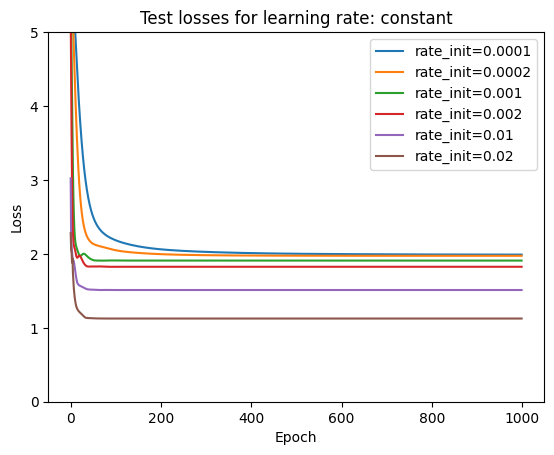

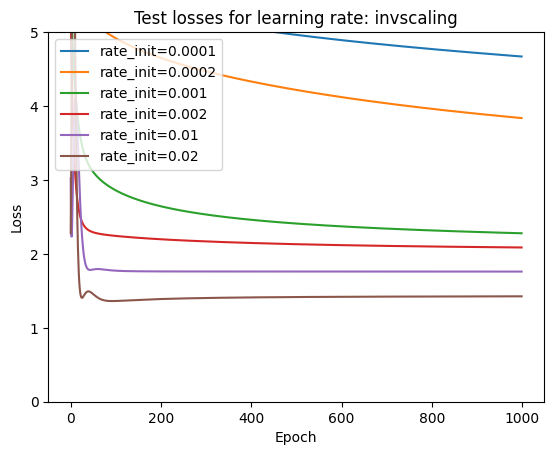

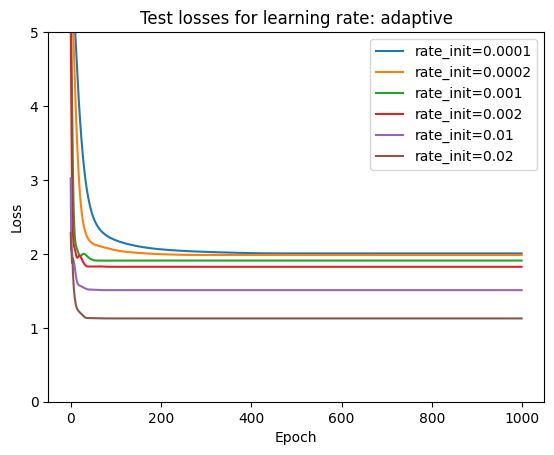

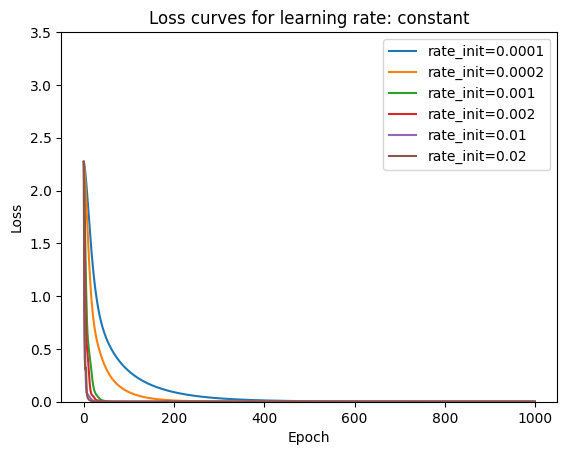

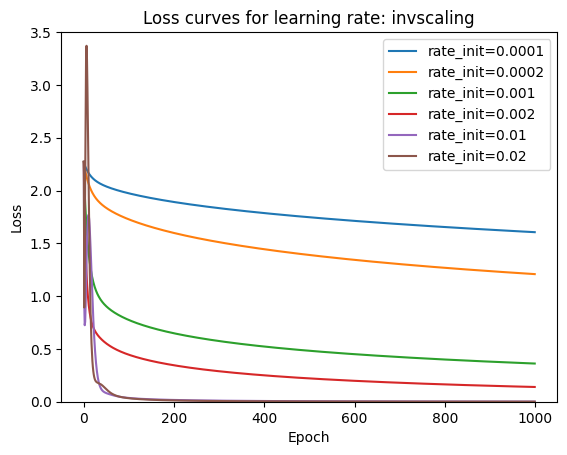

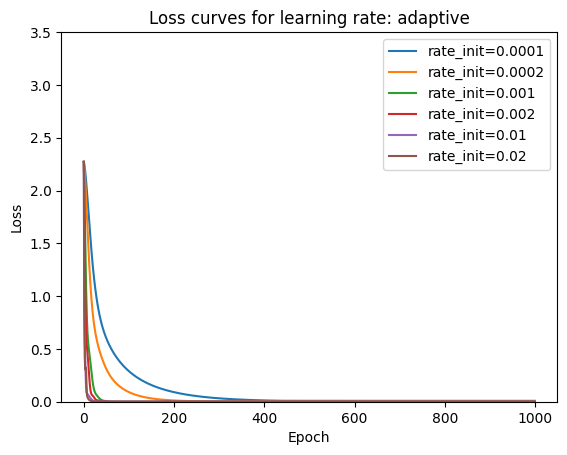

In [11]:
# 0.1 or more causes: Input contains infinity or a value too large for dtype('float32').
learning_rates_init_values = [0.0001, 0.0002, 0.001, 0.002, 0.01, 0.02]
learning_rates_values = ['constant', 'invscaling', 'adaptive']

# train losses:
for rate in learning_rates_values:
    plt.figure()
    plt.title(f'Train losses for learning rate: {rate}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    for rate_init in learning_rates_init_values:
        train_loss = run('train', _learning_rate=rate, _learning_rates_init=rate_init, _hidden_layer_sizes=(100,), _random_state=3, _alpha=0.0)
        plt.plot(range(len(train_loss)), train_loss, label=f'rate_init={rate_init}')
    
    plt.ylim(0, 4.5)
    plt.legend()
    plt.show()

# test losses:
for rate in learning_rates_values:
    plt.figure()
    plt.title(f'Test losses for learning rate: {rate}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    for rate_init in learning_rates_init_values:
        test_loss = run('test', _learning_rate=rate, _learning_rates_init=rate_init, _hidden_layer_sizes=(100,), _random_state=3, _alpha=0.0)
        plt.plot(range(len(test_loss)), test_loss, label=f'rate_init={rate_init}')
    
    plt.ylim(0, 5)
    plt.legend()
    plt.show()

# loss curves:
for rate in learning_rates_values:
    plt.figure()
    plt.title(f'Loss curves for learning rate: {rate}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    for rate_init in learning_rates_init_values:
        loss_curve = run('loss_curve', _learning_rate=rate, _learning_rates_init=rate_init, _hidden_layer_sizes=(100,), _random_state=3, _alpha=0.0)
        plt.plot(range(len(loss_curve)), loss_curve, label=f'rate_init={rate_init}')
    
    plt.ylim(0, 3.5)
    plt.legend()
    plt.show()

#### Badanie wpływu rozmiaru modelu MLP na otrzymywane wyniki

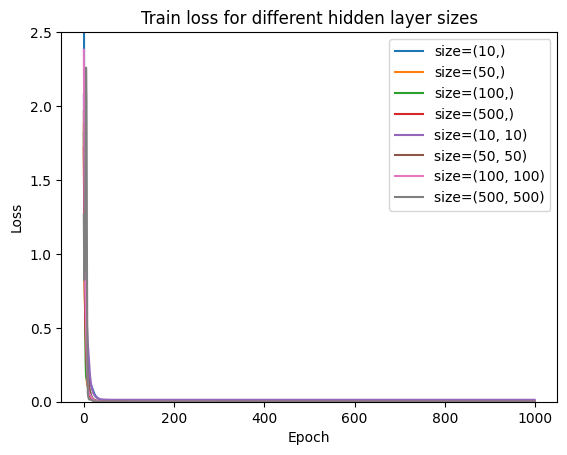

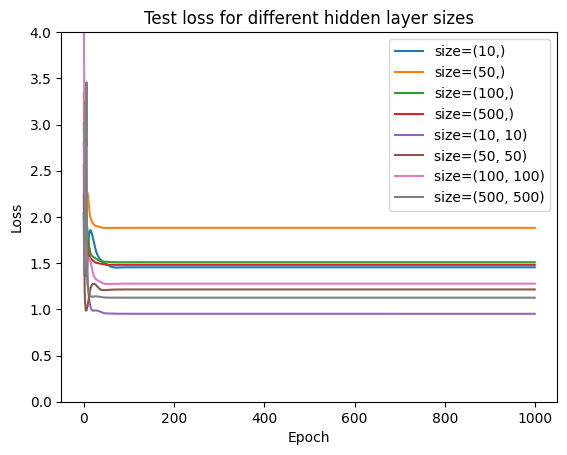

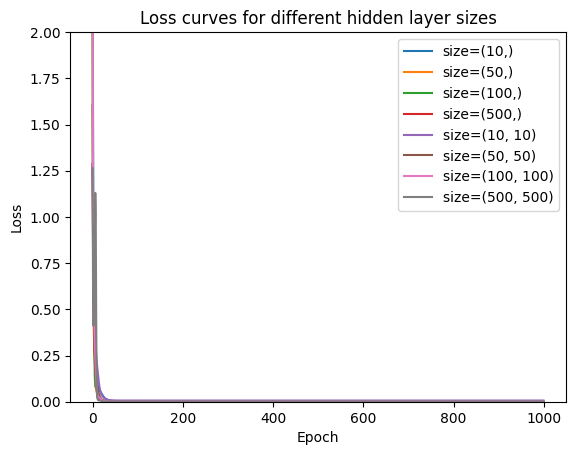

In [24]:
hidden_layer_sizes_values = [(10,), (50,), (100,), (500,),
                             (10, 10), (50, 50,), (100, 100,), (500, 500,)]

# train losses:
plt.figure()
plt.title(f'Train loss for different hidden layer sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
for size in hidden_layer_sizes_values:
    train_loss = run('train', _learning_rate='adaptive', _learning_rates_init=0.01, _hidden_layer_sizes=size, _random_state=3, _alpha=0.0)
    plt.plot(range(len(train_loss)), train_loss, label=f'size={size}')
plt.ylim(0, 2.5)
plt.legend()
plt.show()
    
# test losses:
plt.figure()
plt.title(f'Test loss for different hidden layer sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
for size in hidden_layer_sizes_values:
    test_loss = run('test', _learning_rate='adaptive', _learning_rates_init=0.01, _hidden_layer_sizes=size, _random_state=3, _alpha=0.0)
    plt.plot(range(len(test_loss)), test_loss, label=f'size={size}')
plt.ylim(0, 4)
plt.legend()
plt.show()

# loss curves:
plt.figure()
plt.title(f'Loss curves for different hidden layer sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
for size in hidden_layer_sizes_values:
    loss_curve = run('loss_curve', _learning_rate='adaptive', _learning_rates_init=0.01, _hidden_layer_sizes=size, _random_state=3, _alpha=0.0)
    plt.plot(range(len(loss_curve)), loss_curve, label=f'size={size}')
plt.ylim(0, 2)
plt.legend()
plt.show()

##### Badanie wpływu regularyzacji na otrzymywane wyniki:

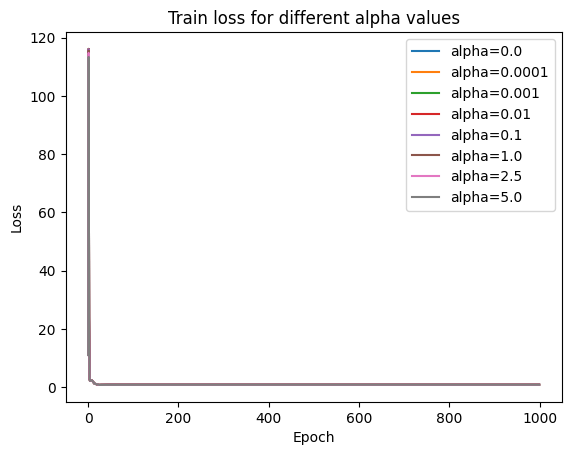

In [8]:
alpha_values=[0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.5, 5.0]

# train losses:
plt.figure()
plt.title(f'Test loss for different alpha values')
plt.xlabel('Epoch')
plt.ylabel('Loss')
for alpha in alpha_values:
    train_loss = run('test', _learning_rate='constant', _learning_rates_init=0.01, _hidden_layer_sizes=(2000,2000,), _random_state=3, _alpha=alpha)
    plt.plot(range(len(train_loss)), train_loss, label=f'alpha={alpha}')
plt.legend()
plt.show()

Najlepsza konfiguracja na podstawie otrzymanych do tej pory wyników:

Stałe
- solver: sgd
- random_state: 3 

Zmienne:
- hidden_layer_sizes: (100, 100,)
- learning_rate: adaptive
- learning_rate_init: 0.01
- alpha: 2.5

#### Testowanie najlepszej konfiguracji modelu MLP na własnych dowcipach

In [15]:
best_model = MLPRegressor(
    solver='sgd',
    random_state=3,
    alpha=2.5,
    hidden_layer_sizes=(100,100,),
    learning_rate='adaptive',
    learning_rate_init=0.01,
    max_iter=1000,
)
best_model.fit(x_train_scaled, y_train)

MLPRegressor(alpha=2.5, hidden_layer_sizes=(100, 100), learning_rate='adaptive',
             learning_rate_init=0.01, max_iter=1000, random_state=3,
             solver='sgd')

In [16]:
def rate_my_joke(joke: str):
    embeeded_joke = model.encode([joke])
    embeeded_joke = np.reshape(embeeded_joke, (1, -1))
    #print(embeeded_joke.shape)
    
    prediction = best_model.predict(embeeded_joke)
    print(f'\nMy joke: {joke}\nMy joke rating on a scale [-10, 10]: {prediction}')

In [1]:
print(f'Max mean rating: {np.max(ratings)}')
print(f'Min mean rating: {np.min(ratings)}')
rate_my_joke("What vegetable should you never take on boat with you ? A leek !")
rate_my_joke("Why was six afraid of seven? Because 7-8-9.")
rate_my_joke("Whats the best thing about Switzerland? I dont know, but the flag is a big plus.")
rate_my_joke("Why don't scientists trust stairs? Because they're always changing steps and trying to elevate their game!")
rate_my_joke("My brother came back from school all motivated because he said he would be following a new diet from that day. We didn't really give it much thought until my brother really started eating his homework for dinner. When we stopped him and asked why he was doing that, he replied: I was just trying to see how it tasted because my teacher said that the homework would be a piece of cake for me.")
rate_my_joke("A businessman went into the office and found an inexperienced handyman painting the walls. The handyman was wearing two heavy parkas on a hot summer day. Thinking this was a little strange, the businessman asked the handyman why he was wearing the parkas on such a hot day. The handyman showed him the instructions on the can of paint. They read: “For best results, put on two coats.”")
rate_my_joke("How does dry skin affect you at work? You dont have any elbow grease to put into it.")
rate_my_joke("Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.")
rate_my_joke("I just finished my last assignment for this course")

NameError: name 'np' is not defined